## 聚类比较

考虑了以下数据集：(其中124567是参考了scikit网站上的demo测试数据集，而3是自己设置的更为复杂的数据集，8是一个实际问题的数据集，即iris数据集)

1. noisy_circle
2. noisy_moons
3. noisy_complex
4. blobs
5. varied: blobs with varied variances
6. aniso: anisotropicly distribution
7. no_structure
8. iris dataset

考虑了如下聚类算法的结果

1. KMeans, MinBatchKMeans
2. AgglomerativeClustering: Ward, and average link
3. Birch
4. DBSCAN
5. AP
6. GaussianMixtureModel
7. spectral clustering

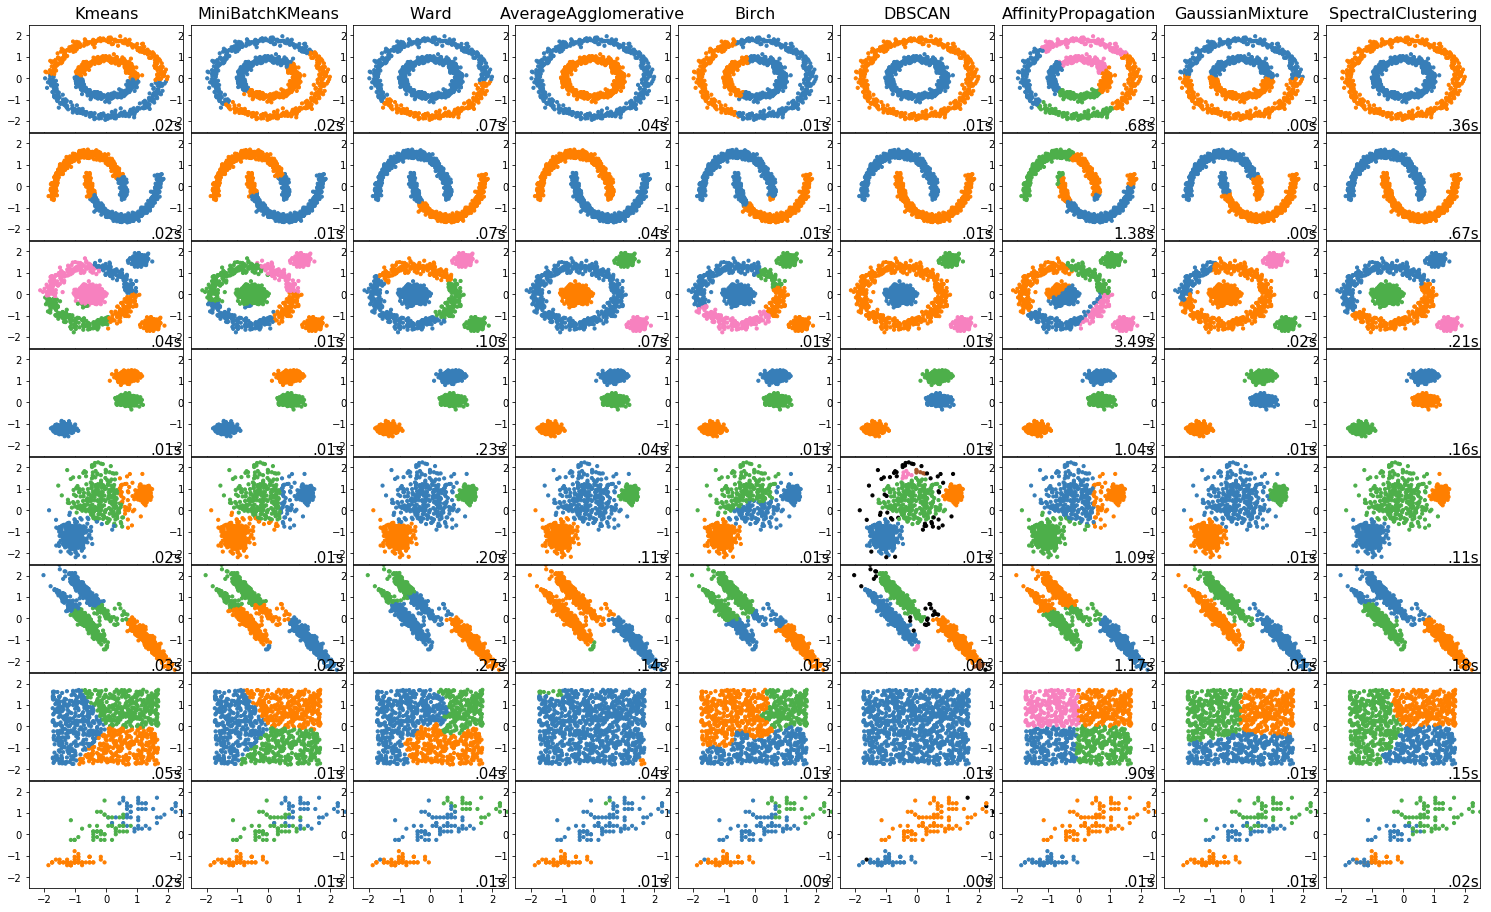

In [43]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import time
import warnings

%matplotlib inline

np.random.seed(1)
n_samples = 1000

"""
# Generate datasets. We choose size typical datesets 
named:
1. noisy_circle
2. noisy_moons
3. noisy_complex
4. blobs
5. varied: blobs with varied variances
6. aniso: anisotropicly distribution
7. no_structure
8. iris dataset
"""

noisy_circles = datasets.make_circles(n_samples=n_samples, 
            factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X1, y1 = datasets.make_circles(n_samples=1000, factor=.2, noise=.1)
X2, y2 = datasets.make_blobs(n_samples=200, n_features=2, 
            centers=[[1.2,1.2]], cluster_std=[[.1]],
            random_state=9)
X3, y3 = datasets.make_blobs(n_samples=200, n_features=2, 
            centers=[[1.5,-1.0]], cluster_std=[[.1]],
            random_state=9)
noisy_complex = np.concatenate((X1, X2, X3)), None
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
varied = datasets.make_blobs(n_samples=n_samples,
            cluster_std=[1.0, 2.5, 0.5],
            random_state=170)
X, y = datasets.make_blobs(n_samples=n_samples, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)
no_structure = np.random.rand(n_samples, 2), None
iris = datasets.load_iris().data, datasets.load_iris().target

"""
# Setup clustering parameters
"""
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}
datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (noisy_complex, {'damping': .77, 'preference': -200,
                     'quantile': .2, 'n_clusters': 4}),
    (blobs, {}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (no_structure, {}),
    (iris, {'eps': .8, 'n_neighbors': 2, 'n_clusters':3,
            'xi': 0.1, 'min_cluster_size': .2})]

"""
# Test series clustering methods and plot figures
"""
plot_num = 1
# loop in datasets
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters for datasets
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset
    # normalize dataset
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # symmetrizied
    connectivity = 0.5 * (connectivity + connectivity.T)

    """
    # Create cluster objects
    """
    # kmeans
    kmeans = cluster.KMeans(n_clusters=params['n_clusters'])
    mbkmeans = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    # agglomerative
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    # density approach
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    # model based
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")

    clustering_algorithms = (
        ('Kmeans', kmeans),
        ('MiniBatchKMeans', mbkmeans),
        ('Ward', ward),
        ('AverageAgglomerative', average_linkage),
        ('Birch', birch),
        ('DBSCAN', dbscan),
        ('AffinityPropagation', affinity_propagation),
        ('GaussianMixture', gmm),
        ('SpectralClustering', spectral)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=16)

        colors = np.array(list(islice(cycle(
            ['#377eb8', '#ff7f00', '#4daf4a',
             '#f781bf', '#a65628', '#984ea3',
             '#999999', '#e41a1c', '#dede00']),
            int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        
        plt.scatter(X[:, 0], X[:, -1], s=10, color=colors[y_pred])
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
plt.savefig('clustering_comp.png')
plt.show()

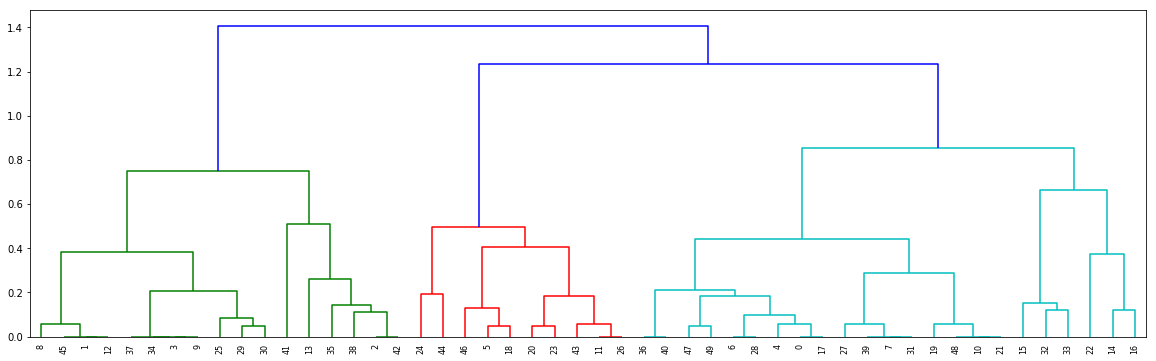

[0 1 1 1 0 2 0 0 1 1 0 2 1 1 0 0 0 0 2 0 2 0 0 2 2 1 2 0 0 1 1 0 0 0 1 1 0
 1 1 0 0 1 1 2 2 1 2 0 0 0]


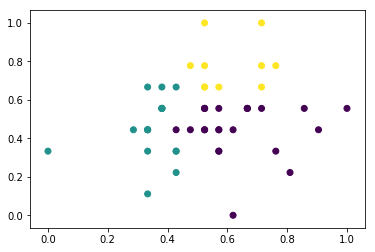

In [44]:
from sklearn import datasets
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering

iris = datasets.load_iris()
iris_data = iris.data
#print(iris_data)

data = np.array(iris_data[:50,1:-1])
min_max_scaler = preprocessing.MinMaxScaler()
data_M = min_max_scaler.fit_transform(data)
#print(data_M)

from scipy.cluster.hierarchy import linkage, dendrogram
%matplotlib inline

plt.figure(figsize=(20,6))
Z = linkage(data_M, method='ward', metric='euclidean')
p = dendrogram(Z, 0)
plt.show()

ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
ac.fit(data_M)

labels = ac.fit_predict(data_M)
print(labels)

plt.scatter(data_M[:,0], data_M[:,1], c=labels)
plt.savefig('')
plt.show()